In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import small_strato_f90.kpp4py as kpp4py

In [3]:
df_range = pd.read_csv('small_strato_range.csv', index_col=0)
df_range

,min,max
O1D,1.000000e-08,1.550810e+02
O,1.000000e-08,1.040641e+09
O3,5.377002e+11,8.486620e+11
NO,1.000000e-08,9.433271e+08
NO2,1.531729e+08,1.096500e+09


In [4]:
np.append(df_range['min'],0)

array([  1.00000000e-08,   1.00000000e-08,   5.37700220e+11,
         1.00000000e-08,   1.53172909e+08,   0.00000000e+00])

In [5]:
y0_list = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 6) )
y0_list.shape

(5000, 6)

In [6]:
%time y1_list = kpp4py.onestep(y0_list.T).T
y1_list.shape

CPU times: user 99.1 ms, sys: 1.24 ms, total: 100 ms
Wall time: 101 ms


(5000, 5)

In [7]:
df_range.index

Index(['O1D', 'O', 'O3', 'NO', 'NO2'], dtype='object')

In [8]:
df_y1 = pd.DataFrame(y1_list, columns=df_range.index)
df_y1.index.name = 'time'
df_y1.head()

,O1D,O,O3,NO,NO2
time,,,,,
0,21.957841,2.307980e+08,7.786747e+11,7.005818e+08,4.412792e+08
1,4.419833,8.187581e+07,8.096660e+11,4.258441e+08,6.768313e+08
2,8.482972,1.229985e+08,7.982983e+11,7.334371e+08,8.066392e+08
3,106.739793,7.225634e+08,5.962463e+11,5.164995e+08,9.152334e+07
4,3.935642,7.407234e+07,7.454267e+11,5.269187e+08,8.019619e+08


In [9]:
df_y1.agg(['min', 'max']).T

,min,max
O1D,2.120252e-05,1.565499e+02
O,1.222626e+05,1.050742e+09
O3,5.374734e+11,8.506460e+11
NO,5.212953e+06,1.612665e+09
NO2,3.155395e+07,1.819113e+09


# Normalize data

In [10]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:5])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
X_train = np.append(normalizer.transform(y0_list[:,0:5]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 6)

In [12]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 0.85919934,  0.84716111,  0.99384073,  1.2709902 ,  1.04302031])

# Fit ANN

In [13]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [14]:
H1, H2 = 10, 10

model = torch.nn.Sequential(
    torch.nn.Linear(6, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 5)
)

In [15]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 0.0003501904720906168
40 0.00013025895168539137
60 6.947971996851265e-05
80 5.3778261644765735e-05
100 4.2751871660584584e-05
120 3.4051616239594296e-05
140 2.7901889552595094e-05
160 2.4750914235482924e-05
180 2.125240644090809e-05
200 1.9092951333732344e-05


In [16]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 13.1 ms, sys: 1.07 ms, total: 14.2 ms
Wall time: 7.37 ms


In [17]:
y_pred_numpy.shape

(5000, 5)

In [18]:
r2_score(y_pred_numpy, Y_train)

0.99998048340752099

# Test set

In [19]:
y0_test = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(20000, 6) )
y0_list.shape

(5000, 6)

In [20]:
%time y1_test = kpp4py.onestep(y0_test.T).T

CPU times: user 625 ms, sys: 3.13 ms, total: 628 ms
Wall time: 413 ms


In [21]:
X_test = np.append(normalizer.transform(y0_test[:,0:5]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [22]:
Y_test.shape

(20000, 5)

In [23]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 13.6 ms, sys: 3.07 ms, total: 16.6 ms
Wall time: 10.6 ms


In [24]:
r2_score(y_test_pred, Y_test)

0.99997977258341741

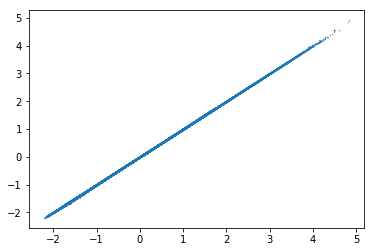

In [25]:
plt.scatter(y_test_pred, Y_test, s=0.1)